# Polymarket Price Prediction - Interactive Notebook

This notebook demonstrates the complete machine learning pipeline for predicting Polymarket prices.

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collect_polymarket_data import PolymarketDataCollector
from feature_engineering import PolymarketFeatureEngineering
from train_model import PolymarketPredictor
from predict_markets import PolymarketLivePredictor

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')

print("✓ Imports complete")

✓ Imports complete


## 1. Data Collection

Fetch historical data from Polymarket

In [2]:
# Initialize collector
collector = PolymarketDataCollector()

# Get active markets
markets = collector.get_active_markets(limit=20)

print(f"Found {len(markets)} markets\n")
print("Sample markets:")
for i, market in enumerate(markets[:5]):
    print(f"{i+1}. {market.get('question', 'N/A')[:70]}")

2025-12-27 00:23:06,860 - INFO - Retrieved 1000 markets from CLOB API


Found 20 markets

Sample markets:
1. NCAAB: Arizona State Sun Devils vs. Nevada Wolf Pack 2023-03-15
2. NCAAB: Tennessee Volunteers vs. Duke Blue Devils 2023-03-18
3. NBA: LA Clippers vs. Orlando Magic 2023-03-18
4. [Single Market] Will Glenn Youngkin win the 2024 Republican presidenti
5. NBA: Miami Heat vs. Cleveland Cavaliers 2023-03-08


In [3]:
# Collect detailed data for markets
datasets = collector.collect_multiple_markets(num_markets=10, resample_freq='1H')

print(f"Collected {len(datasets)} market datasets")

# Save the data
if datasets:
    collector.save_datasets(datasets)
    print("✓ Data saved")

2025-12-27 00:23:16,136 - INFO - Retrieved 1000 markets from CLOB API
2025-12-27 00:23:16,141 - INFO - Processing market 1/10
2025-12-27 00:23:16,142 - INFO - Collecting data for: NCAAB: Arizona State Sun Devils vs. Nevada Wolf Pack 2023-03-15
2025-12-27 00:23:16,246 - ERROR - Error fetching trades for 0x5eed579ff6763914d78a966c83473ba2485ac8910d0a0914eef6d9fcb33085de: 401 Client Error: Unauthorized for url: https://clob.polymarket.com/trades?condition_id=0x5eed579ff6763914d78a966c83473ba2485ac8910d0a0914eef6d9fcb33085de&limit=10000
2025-12-27 00:23:16,251 - WARNING - No trades found for 0x5eed579ff6763914d78a966c83473ba2485ac8910d0a0914eef6d9fcb33085de
2025-12-27 00:23:17,252 - INFO - Processing market 2/10
2025-12-27 00:23:17,252 - INFO - Collecting data for: NCAAB: Tennessee Volunteers vs. Duke Blue Devils 2023-03-18
2025-12-27 00:23:17,356 - ERROR - Error fetching trades for 0x8901bf367fcb32b406b54e8deb1bcb3320fdc4a994bd7f0a7a1fe72956dc1c9a: 401 Client Error: Unauthorized for url: 

Collected 0 market datasets


## 2. Explore Collected Data

In [4]:
# Load and explore data
with open('polymarket_data/polymarket_training_data.json', 'r') as f:
    data = json.load(f)

# Show summary statistics
summary_df = pd.read_csv('polymarket_data/polymarket_training_data_summary.csv')
display(summary_df.head())

# Statistics
print(f"\nDataset Statistics:")
print(f"Total markets: {len(data)}")
print(f"Average trades per market: {summary_df['total_trades'].mean():.0f}")
print(f"Average volume: ${summary_df['total_volume'].mean():,.0f}")

,question,condition_id,total_trades,total_volume,avg_price,price_std,price_min,price_max,price_range,price_change,price_change_pct,time_span_hours,trades_per_hour
0,Sample Market 1: Will event 1 occur?,0x00000000000000000000000000000000000000000000...,100,1138512.0,0.651592,0.127233,0.378146,0.791960,0.413813,0.270192,57.630821,200,0.5
1,Sample Market 2: Will event 2 occur?,0x00000000000000000000000000000000000000000000...,100,1061743.0,0.566162,0.092684,0.364151,0.755746,0.391595,0.232087,48.258562,200,0.5
2,Sample Market 3: Will event 3 occur?,0x00000000000000000000000000000000000000000000...,100,1126410.0,0.597147,0.068573,0.427356,0.682412,0.255056,-0.081495,-16.015542,200,0.5
3,Sample Market 4: Will event 4 occur?,0x00000000000000000000000000000000000000000000...,100,1104883.0,0.456081,0.055537,0.367839,0.631007,0.263168,-0.119604,-23.018228,200,0.5
4,Sample Market 5: Will event 5 occur?,0x00000000000000000000000000000000000000000000...,100,1107780.0,0.652256,0.063563,0.479371,0.772864,0.293493,0.048954,9.631733,200,0.5



Dataset Statistics:
Total markets: 20
Average trades per market: 100
Average volume: $1,101,606


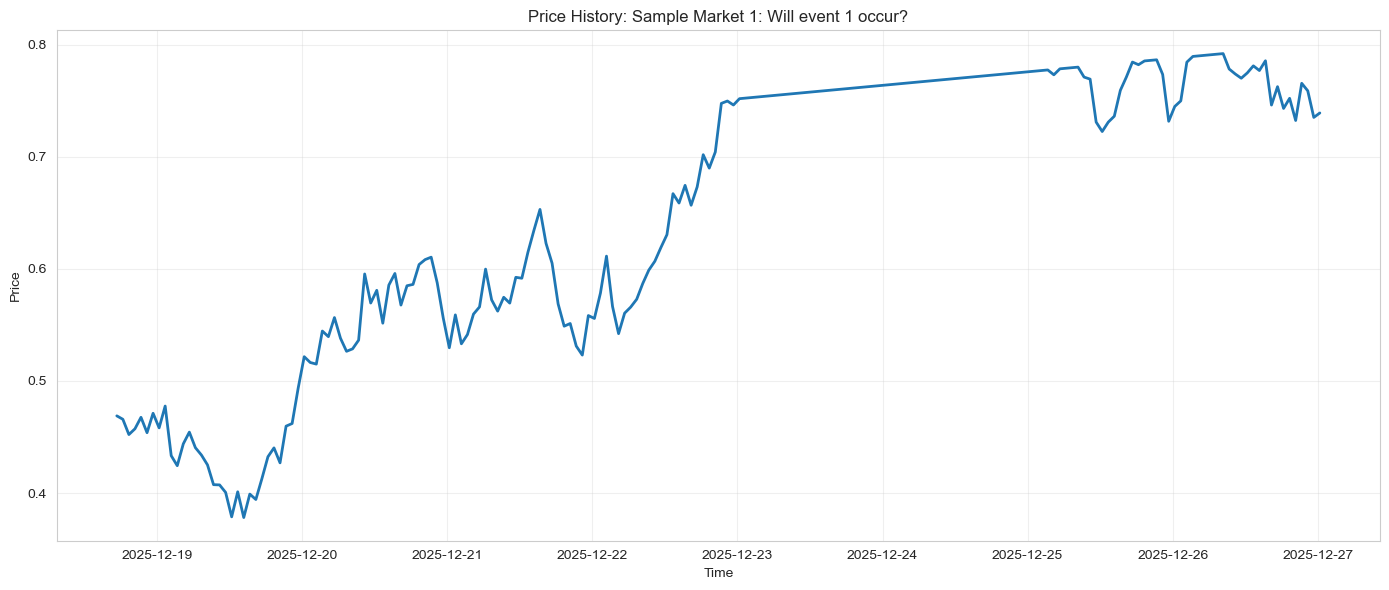

In [5]:
# Visualize a sample market's price history
sample_market = data[0]
timeseries = pd.DataFrame(sample_market['timeseries'])

if not timeseries.empty and 'timestamp' in timeseries and 'close' in timeseries:
    timeseries['timestamp'] = pd.to_datetime(timeseries['timestamp'])
    
    plt.figure(figsize=(14, 6))
    plt.plot(timeseries['timestamp'], timeseries['close'], linewidth=2)
    plt.title(f"Price History: {sample_market['market_info']['question'][:70]}")
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 3. Feature Engineering

In [6]:
# Initialize feature engineer
engineer = PolymarketFeatureEngineering()

# Load datasets
datasets = engineer.load_data('polymarket_data/polymarket_training_data.json')

# Prepare training data
training_df = engineer.prepare_training_data(datasets, prediction_horizon=6)

print(f"Training dataset shape: {training_df.shape}")
print(f"Features: {len(engineer.get_feature_columns(training_df))}")
print(f"\nTarget distribution:")
print(training_df['target_binary'].value_counts())

2025-12-27 00:24:01,850 - INFO - Loaded 20 markets from polymarket_data/polymarket_training_data.json
2025-12-27 00:24:02,085 - INFO - Created dataset with 4000 samples


Training dataset shape: (4000, 50)
Features: 42

Target distribution:
0    2077
1    1923
Name: target_binary, dtype: int64


In [ ]:
# Explore feature distributions
feature_cols = engineer.get_feature_columns(training_df)

# Show first few features
print("Sample features:")
for col in feature_cols[:10]:
    print(f"  - {col}")

# Display feature statistics
display(training_df[feature_cols[:10]].describe())

In [ ]:
# Visualize feature correlations
selected_features = ['momentum_1h', 'momentum_6h', 'volatility_6h', 
                    'volume_change', 'rsi', 'target_binary']
available_features = [f for f in selected_features if f in training_df.columns]

if len(available_features) > 1:
    plt.figure(figsize=(10, 8))
    sns.heatmap(training_df[available_features].corr(), 
                annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlations')
    plt.tight_layout()
    plt.show()

## 4. Model Training

In [ ]:
# Initialize predictor
predictor = PolymarketPredictor()

# Prepare features and target
X, y = predictor.prepare_features_and_target(training_df)

# Split data
data_splits = predictor.split_data(X, y, test_size=0.2, val_size=0.1)

# Scale features
data_splits = predictor.scale_features(data_splits)

print("✓ Data prepared for training")

In [ ]:
# Train and compare models
results = predictor.compare_models(data_splits)

In [ ]:
# Compare model performance
comparison_df = pd.DataFrame({
    'Model': [],
    'Train Accuracy': [],
    'Val Accuracy': [],
    'Val F1': [],
    'Val ROC AUC': []
})

for name, result in results.items():
    comparison_df = pd.concat([comparison_df, pd.DataFrame([{
        'Model': name,
        'Train Accuracy': result['train_metrics']['accuracy'],
        'Val Accuracy': result['val_metrics']['accuracy'],
        'Val F1': result['val_metrics']['f1'],
        'Val ROC AUC': result['val_metrics']['roc_auc']
    }])], ignore_index=True)

display(comparison_df)

In [ ]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics = ['Val Accuracy', 'Val F1', 'Val ROC AUC']
for i, metric in enumerate(metrics):
    axes[i].bar(comparison_df['Model'], comparison_df[metric])
    axes[i].set_title(metric)
    axes[i].set_ylim([0, 1])
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Select and save best model
best_model_name, best_model = predictor.select_best_model(results)

# Final test evaluation
test_metrics = predictor.evaluate_model(
    best_model,
    data_splits['X_test_scaled'],
    data_splits['y_test'],
    "Test"
)

# Save model
predictor.model = best_model
predictor.save_model(best_model)

## 5. Feature Importance Analysis

In [ ]:
# Plot feature importance (if Random Forest)
if best_model_name == 'Random Forest' and predictor.feature_importance is not None:
    top_n = 20
    top_features = predictor.feature_importance.head(top_n)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(data=top_features, x='importance', y='feature')
    plt.title(f'Top {top_n} Most Important Features')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Features:")
    display(top_features.head(10))

## 6. Make Live Predictions

In [ ]:
# Load predictor for live markets
live_predictor = PolymarketLivePredictor()

# Get top markets
condition_ids = live_predictor.get_top_markets_to_predict(limit=5)

print(f"Found {len(condition_ids)} markets for prediction")

In [ ]:
# Make predictions
if condition_ids:
    predictions = live_predictor.predict_multiple_markets(condition_ids)
    
    # Display predictions
    pred_df = pd.DataFrame([{
        'Question': p['question'][:50] + '...',
        'Prediction': p['prediction_label'],
        'Probability': f"{p['probability']:.2%}",
        'Confidence': p['confidence'],
        'Current Price': p['current_price']
    } for p in predictions])
    
    display(pred_df)

In [ ]:
# Visualize prediction confidence distribution
if predictions:
    confidences = [p['probability'] for p in predictions]
    
    plt.figure(figsize=(10, 5))
    plt.hist(confidences, bins=10, edgecolor='black')
    plt.axvline(x=0.5, color='red', linestyle='--', label='Neutral (50%)')
    plt.xlabel('Prediction Probability')
    plt.ylabel('Count')
    plt.title('Distribution of Prediction Confidence')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 7. Model Insights & Summary

In [ ]:
# Print comprehensive summary
print("="*80)
print("MODEL PERFORMANCE SUMMARY")
print("="*80)
print(f"\nBest Model: {best_model_name}")
print(f"\nTest Set Metrics:")
print(f"  Accuracy:  {test_metrics['accuracy']:.2%}")
print(f"  Precision: {test_metrics['precision']:.2%}")
print(f"  Recall:    {test_metrics['recall']:.2%}")
print(f"  F1 Score:  {test_metrics['f1']:.4f}")
print(f"  ROC AUC:   {test_metrics['roc_auc']:.4f}")
print(f"\nTraining Data:")
print(f"  Markets:   {len(datasets)}")
print(f"  Samples:   {len(training_df)}")
print(f"  Features:  {len(predictor.feature_names)}")
print("="*80)